# Ocean Currents

This notebook runs ocean currents experiments in setting where $\sigma \rightarrow 0$

We assess performance of CURLY-FM on real ocean currents dataset acquired from a HYbrid Coordinate Ocean Model (HYCOM) reanalysis released by US Department of Defense.

This data consists of real ocean currents measurements in Gulf of Mexico acquired at 1km bathymetry, providing hourly ocean currents velocity fields for the geographic region between 98E and 77E in longitude and 18N to 32N in latitude at each day since January 1st, 2001.

We leverage experimental set-up as presented in [1], and focus on a specific time point at 17:00 UTC on June 1st, 2024, extracting ocean surface velocity field that contains a vortex. From a point near its center, we uniformly draw 1,000 initial positions whithin radius 0.05 and evolve them across nine time steps such that ∆t = 0.9, computing velocities by the nearest grid node for ∼ 111 observations per time step.

**References**

[1] Shen, Yunyi, Renato Berlinghieri, and Tamara Broderick. "Multi-marginal schrödinger bridges with iterative reference refinement." arXiv preprint arXiv:2408.06277 (2024).

In [1]:
%load_ext autoreload
%autoreload 2
import os
import time

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import scanpy as sc
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
import anndata as ad
import pandas as pd
import scvelo as scv
import torch

from torchcfm import optimal_transport
from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, torch_wrapper

2025-11-30 21:56:29.348248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 21:56:29.363716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764539789.380038 3944402 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764539789.384898 3944402 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764539789.398417 3944402 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# set seed
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load Oceans data
from pathlib import Path
ROOT = Path.cwd().resolve()
while ROOT != ROOT.parent and not ((ROOT / ".git").exists() or (ROOT / "pyproject.toml").exists() or (ROOT / "setup.py").exists()):
    ROOT = ROOT.parent

path = ROOT / "data" / "oceans" / "oceans.npz"
loaded_data = np.load(path)
positions, velocities = loaded_data["positions"], loaded_data["velocities"]
print(positions.shape, velocities.shape)

num_times = positions.shape[0]
num_particles = positions.shape[1]
d = positions.shape[-1]

k = 20 # knn number

(9, 111, 2) (9, 111, 2)


In [5]:
from scipy.interpolate import griddata

def plot_stream_vectorfield(x, v, ax = None, x_min = None, x_max = None, y_min = None, y_max = None, N = 15, linewidth = None, lw0 = 1.0, **kwargs):
    x_min = x[:, 0].min() if x_min is None else x_min
    x_max = x[:, 0].max() if x_max is None else x_max
    y_min = x[:, 0].min() if y_min is None else y_min
    y_max = x[:, 0].max() if y_max is None else y_max
    _x, _y = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    _u = griddata((x[:, 0], x[:, 1]), v[:, 0], (_x, _y), method='linear', fill_value = 0)
    _v = griddata((x[:, 0], x[:, 1]), v[:, 1], (_x, _y), method='linear', fill_value = 0)
    speed = np.sqrt(_u**2 + _v**2)
    lw = 5*speed / speed.max() * lw0
    if ax is None:
        plt.streamplot(_x, _y, _u, _v, linewidth = lw if linewidth is None else linewidth, **kwargs)
    else:
        ax.streamplot(_x, _y, _u, _v, linewidth = lw if linewidth is None else linewidth, **kwargs)

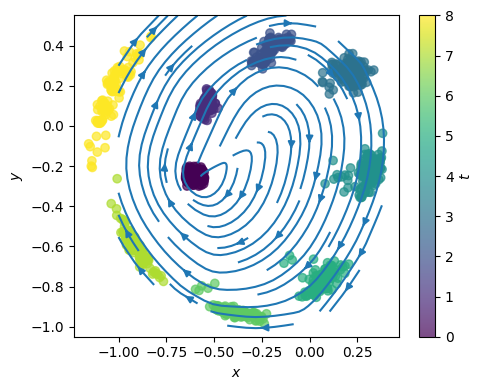

In [6]:
plt.figure(figsize=(5, 4))

plot_stream_vectorfield(
    positions.reshape(-1, d),
    velocities.reshape(-1, d),
    linewidth=1.5,
    x_min=-1.0,
    x_max=0.5,
    y_min=-1.05,
    y_max=0.55,
    lw0=1.5,
    N=15,
)

# Flatten all positions and create corresponding time labels
all_x = []
all_y = []
all_t = []

for t in range(num_times):
    x = positions[t][:, 0]
    y = positions[t][:, 1]
    all_x.append(x)
    all_y.append(y)
    all_t.append(np.full_like(x, t))

all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)
all_t = np.concatenate(all_t)

# Scatter with color as time
sc = plt.scatter(all_x, all_y, c=all_t, cmap="viridis", alpha=0.7)

plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
cbar = plt.colorbar(sc)
cbar.set_label(r"$t$")
plt.tight_layout()
plt.show()

In [7]:
train_ts = [0, 2, 4, 6, 8]
test_ts = [1, 3, 5, 7]

x_train, v_train = [], []
x_test, v_test = [], []

for t in range(num_times):
    if t in train_ts:
        x_train.append(positions[t])
        v_train.append(velocities[t])
    elif t in test_ts:
        x_test.append(positions[t])
        v_test.append(velocities[t])
        
x_train = np.stack(x_train)
v_train = np.stack(v_train)
x_test = np.stack(x_test)
v_test = np.stack(v_test)

print(x_train.shape, v_train.shape)
print(x_test.shape, v_test.shape)

(5, 111, 2) (5, 111, 2)
(4, 111, 2) (4, 111, 2)


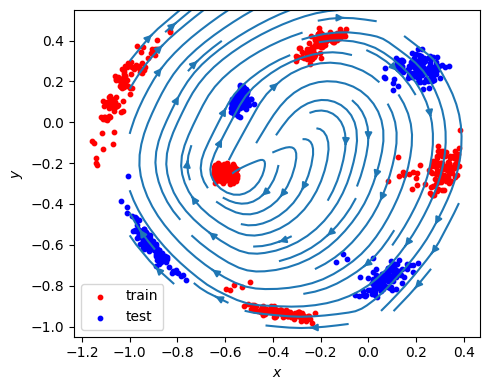

In [8]:
plt.figure(figsize=(5, 4))
plot_stream_vectorfield(
    positions.reshape(-1, d),
    velocities.reshape(-1, d),
    linewidth=1.5,
    x_min=-1.0,
    x_max=0.5,
    y_min=-1.05,
    y_max=0.55,
    lw0=1.5,
    N=15,
)
plt.scatter(
    x_train.reshape(-1, d)[:, 0],
    x_train.reshape(-1, d)[:, 1],
    c="red",
    s=10,
    label="train",
)
plt.scatter(
    x_test.reshape(-1, d)[:, 0],
    x_test.reshape(-1, d)[:, 1],
    c="blue",
    s=10,
    label="test",
)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [9]:
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

def plot_trajectories_on_data(
    positions, traj, num_trajectories=15, ts_train=None, ts_test=None
):
    T, N, _ = positions.shape
    _, N_traj, _ = traj.shape

    # Gather train and test positions
    def collect_points(ts):
        x, y, t = [], [], []
        for ti in ts:
            x.append(positions[ti][:, 0])
            y.append(positions[ti][:, 1])
            t.append(np.full(N, ti))
        return np.concatenate(x), np.concatenate(y), np.concatenate(t)

    train_x, train_y, train_t = (
        collect_points(ts_train)
        if ts_train
        else (np.array([]), np.array([]), np.array([]))
    )
    test_x, test_y, test_t = (
        collect_points(ts_test)
        if ts_test
        else (np.array([]), np.array([]), np.array([]))
    )

    # Compute global time range and shared normalization
    all_t = np.concatenate([train_t, test_t])
    norm = Normalize(vmin=all_t.min(), vmax=all_t.max())

    # Plot train points (circles)
    if train_x.size > 0:
        plt.scatter(
            train_x,
            train_y,
            c=train_t,
            cmap="viridis",
            norm=norm,
            alpha=0.7,
            s=20,
            marker="o",
        )

    # Plot test points (X's)
    if test_x.size > 0:
        sc = plt.scatter(
            test_x,
            test_y,
            c=test_t,
            cmap="viridis",
            norm=norm,
            alpha=0.7,
            s=20,
            marker="d",
        )

    # Overlay learned trajectories
    for i in range(min(num_trajectories, N_traj)):
        plt.plot(traj[:, i, 0], traj[:, i, 1], color="grey", alpha=0.1, linewidth=0.5)

    # Custom legend for markers
    legend_elements = [
        Line2D([0], [0], marker='o', linestyle="None", color='black', label='Train', markersize=4),
        Line2D([0], [0], marker='d', linestyle="None", color='black', label='Test', markersize=4),
    ]
    plt.legend(handles=legend_elements, loc="lower left", markerscale=2)
    
    plt.xlabel(r"Longitude")
    plt.ylabel(r"Latitude")
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$t$")
    plt.tight_layout()
    plt.show()


In [10]:
def get_batch(FM_module, X, batch_size, n_times, ts_train, return_noise=False):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    xts = []
    uts = []
    noises = []
    for t_start in range(len(ts_train) - 1):
            
        t_end = t_start + 1
        
        x0 = (
            torch.from_numpy(
                X[t_start][np.random.randint(X[t_start].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )    
        x1 = (
            torch.from_numpy(
                X[t_end][np.random.randint(X[t_end].shape[0], size=batch_size)]
            )
            .float()
            .to(device)
        )
        
        if return_noise:
            t, xt, ut, eps = FM_module.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            noises.append(eps)
        else:
            t, xt, ut = FM_module.sample_location_and_conditional_flow(
                x0, x1, return_noise=return_noise
            )
            
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
        
    t = torch.cat(ts)

    xt = torch.cat(xts)
    ut = torch.cat(uts)
    if return_noise:
        noises = torch.cat(noises)
        return t, xt, ut, noises
    return t, xt, ut


In [11]:
for t in range(len(train_ts) - 1):
    print(t, t + 1/2, train_ts[t], test_ts[t])

0 0.5 0 1
1 1.5 2 3
2 2.5 4 5
3 3.5 6 7


In [12]:
def get_ut_knn_gaussian(
    xt: torch.Tensor,  
    x0: torch.Tensor,  
    x1: torch.Tensor,  
    v0: torch.Tensor,  
    v1: torch.Tensor,  
    k: int = 100,
    eps: float = 1e-12,
):
    x = torch.cat([x0, x1], dim=0)
    v = torch.cat([v0, v1], dim=0)

    dists = torch.cdist(xt, x)

    knn_dists, knn_idx = torch.topk(dists, k=k, dim=1, largest=False)

    h = knn_dists[:, -1:].clamp_min(eps)  
    w = torch.exp(-(knn_dists**2) / (2 * h**2))  
    w = w / (w.sum(dim=1, keepdim=True) + eps)  

    v_knn = v[knn_idx]  
    v_xt = (w.unsqueeze(-1) * v_knn).sum(dim=1)

    return v_xt


In [13]:
import torch.nn.functional as F

class CurlyWrapperWithMetrics(torch.nn.Module):
    def __init__(self, model, x0, x1, v0, v1, k):
        super().__init__()
        self.model = model
        self.x0 = x0
        self.x1 = x1
        self.v0 = v0
        self.v1 = v1
        self.k = k

    def forward(self, t, z, *args, **kwargs):
        x = z[:, :-2]
        x_dot = self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], dim=1))

        u_t = get_ut_knn_gaussian(
            x,
            self.x0,
            self.x1,
            self.v0,
            self.v1,
            k=self.k,
        )

        cos_dist = 1 - F.cosine_similarity(u_t, x_dot, dim=1)
        L2_squared = torch.sum((u_t - x_dot) ** 2, dim=1)

        return torch.cat([x_dot, cos_dist.unsqueeze(1), L2_squared.unsqueeze(1)], dim=1)


## OT-CFM

In [14]:
batch_size = 64
sigma = 0.01
dim = 2
ot_cfm_model = MLP(dim=dim, time_varying=True, w=64).to(device)
ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), 1e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)


100%|██████████| 10000/10000 [00:50<00:00, 198.91it/s]


Text(0, 0.5, 'Loss')

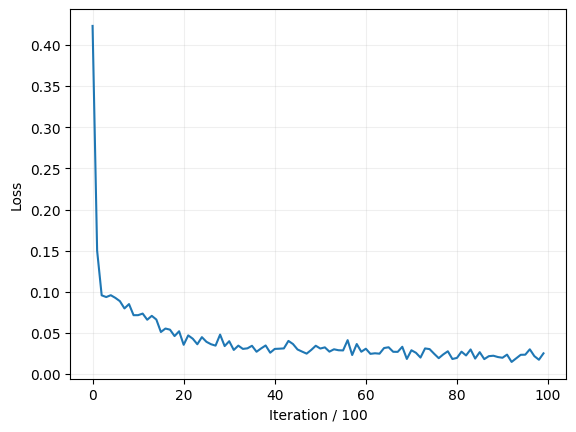

In [15]:
loss_otcfm = []

start_time = time.time()

for i in tqdm(range(10000)):
    ot_cfm_optimizer.zero_grad()
    t, xt, ut = get_batch(FM, x_train, batch_size, num_times, train_ts)
    vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    ot_cfm_optimizer.step()

    if i % 100 == 0:
        loss_otcfm.append(loss.cpu().item())
        
end_time = time.time()

train_time_ot_cfm = end_time - start_time

plt.plot(loss_otcfm)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")
plt.ylabel("Loss")


tensor(0.1602)
tensor(0.1549)
tensor(0.0898)
tensor(0.2580)
Avg Cosine distance:  0.11587578
Avg L2 cost:  0.16572705
Avg Wass-2 distance:  0.2073444951187215

----------------------

t            Cosine-dist    &      L2 cost       &       Wass-2 
t2 --- 0.23555168509483337 & 0.16024699807167053 & 0.14779033827352098 \\
t4 --- 0.126837357878685 & 0.15487568080425262 & 0.23345572232931586 \\
t6 --- 0.0338769294321537 & 0.08975349366664886 & 0.19812941392631947 \\
t8 --- 0.06723716855049133 & 0.2580319941043854 & 0.2500025059457297 \\

OT-CFM training time -- 0:50 (mins:secs)


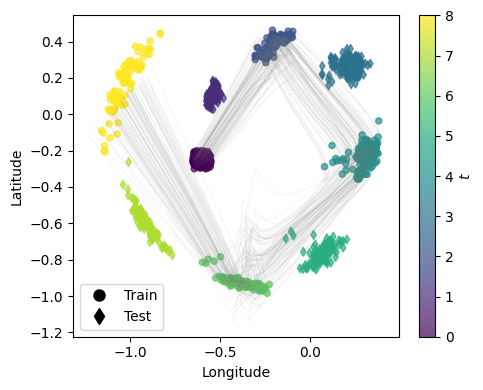

In [16]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)
        v0 = torch.from_numpy(v_train[t]).float().to(device)
        v1 = torch.from_numpy(v_train[t + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(ot_cfm_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        out = node.trajectory(
            z0,
            t_span=torch.linspace(t, t + 1, 100),
        ).cpu()

        traj_tmp = out[:, :, :-2]

        trajs.append(traj_tmp)

    traj_ot_cfm = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1, cos_dist, L2_cost = [], [], []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)
        v0 = torch.from_numpy(velocities[t_train]).float().to(device)
        v1 = torch.from_numpy(velocities[t_train + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(ot_cfm_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        pred_out = node.trajectory(
            z0.to(device),
            t_span=torch.linspace(t, t + 1 / 2, 100),
        ).cpu()

        pred_traj = pred_out[:, :, :-2]
        cosine_traj = pred_out[:, :, -2]
        L2_traj = pred_out[:, :, -1]

        pred = pred_traj[-1]

        cos_dist.append(cosine_traj[-1].cpu().mean())
        L2_cost.append(L2_traj[-1].cpu().mean())

        print(L2_traj[-1].cpu().mean())

        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    cos_dist = np.stack(cos_dist)
    L2_cost = np.stack(L2_cost)

    print("Avg Cosine distance: ", np.mean(cos_dist))
    print("Avg L2 cost: ", np.mean(L2_cost))

    wass1 = np.stack(wass1)
    print("Avg Wass-2 distance: ", np.mean(wass1))
    
    print()
    print("----------------------")
    print()
    print("t            Cosine-dist    &      L2 cost       &       Wass-2 ")
    for i, t_left_out in enumerate(["t2", "t4", "t6", "t8"]):
        print(
            t_left_out + f" --- {cos_dist[i]} & {L2_cost[i]} & {wass1[i]} \\\\"
        )
    
    minutes = int(train_time_ot_cfm // 60)
    seconds = int(train_time_ot_cfm % 60)

    print()
    print(f"OT-CFM training time -- {minutes}:{seconds} (mins:secs)")

    plot_trajectories_on_data(
        positions,
        traj_ot_cfm.cpu().numpy(),
        num_trajectories=100,
        ts_train=train_ts,
        ts_test=test_ts,
    )


## Curly

In [17]:
from torch.func import vmap
import scipy

def get_xt(t, t_start, x0, x1, geodesic_model, sigma=0.0):
    mu_t = (1 - t) * x0 + t * x1 +  t * (1-t) * (geodesic_model(torch.cat([x0, x1, t+t_start], dim=-1)))
    epsilon = torch.randn_like(x0)
    x_t = mu_t + torch.sqrt(t*(1-t))*sigma * epsilon
    return mu_t, x_t, epsilon

def get_xt_xt_dot(t, t_start, t_end, x0, x1, geodesic_model, sigma=0.0):
    # get xt and xt dot from the geodesic model
    with torch.enable_grad():
        t = t[..., None]
        t.requires_grad_(True)
        mu_t, xt, eps = get_xt(t, t_start, x0, x1, geodesic_model, sigma=sigma)
        mu_t_dot_list = []
        for i in range(xt.shape[-1]):
            mu_t_dot_list.append(
                torch.autograd.grad(torch.sum(mu_t[..., i]), t, create_graph=True)[0]
            )
        mu_t_dot = torch.cat(mu_t_dot_list, -1)
    return xt, mu_t_dot, eps

def coupling_geo_new(
    t_start, t_end, x0, x1, x0s, x1s, v0s, v1s, geodesic_model, k, sigma
):
    batch_size, d = x0.shape

    t = torch.rand(1).type_as(x0) * torch.ones((batch_size, batch_size), device=x0.device)
    x0_r = x0.repeat(batch_size, 1, 1)
    x1_r = x1.repeat(batch_size, 1, 1).transpose(0, 1)

    xt, mu_t_dot, eps = get_xt_xt_dot(
        t, t_start, t_end, x0_r, x1_r, geodesic_model, sigma
    )

    ut = vmap(lambda x: get_ut_knn_gaussian(x, x0s, x1s, v0s, v1s, k=k))(xt)

    L2_cost = 0.5 * ((mu_t_dot.detach() - ut) ** 2).sum(-1)
    _, j = scipy.optimize.linear_sum_assignment(L2_cost.detach().cpu().numpy())

    pi_x0 = x0[j]
    pi_x1 = x1

    return pi_x0, pi_x1, eps


In [18]:
def get_batch_geo(geo, X, V, batch_size, sigma, ts_train):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    uts = []
    for t_start in range(len(ts_train) - 1):
        t_end = t_start + 1
        
        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)

        v0 = torch.from_numpy(V[t_start][idcs_0]).float().to(device)
        v1 = torch.from_numpy(V[t_end][idcs_1]).float().to(device)
    
        t = torch.rand(x0.shape[0]).type_as(x0) 
        t_o = t
        
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)
        ut = get_ut_knn_gaussian(
            xt,
            x0,
            x1,
            v0,
            v1,
            k=k,
        )
        xt = xt + torch.sqrt(t* (1-t)).unsqueeze(1) * sigma * eps
        
        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)
    
    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)

    return t_orig, t, xt, ut, mu_t_dot, eps


In [19]:
batch_size = 64
sigma = 0.01
alpha = 1.0
dim = 2
geo_model = MLP(dim=4, out_dim=dim, time_varying=True, w=64).to(device)
geo_optimizer = torch.optim.AdamW(geo_model.parameters(), 1e-4)

100%|██████████| 5000/5000 [01:03<00:00, 79.30it/s]


Text(0, 0.5, 'Loss')

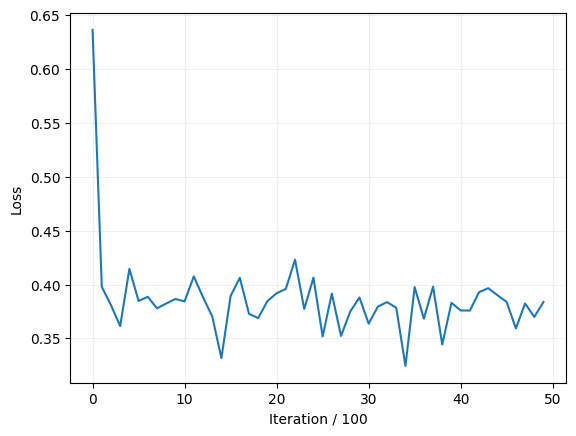

In [20]:
train_loss = []

start_time = time.time()

for i in tqdm(range(5_000)):
    geo_optimizer.zero_grad()
    t_orig, t, xt, ut, mu_t_dot, eps = get_batch_geo(geo_model, x_train, v_train, batch_size, sigma, train_ts)
 
    cosine_loss = 1 - torch.nn.functional.cosine_similarity(ut, mu_t_dot).mean()
    loss = torch.mean((alpha*ut - mu_t_dot) ** 2) + cosine_loss
    
    loss.backward()
    geo_optimizer.step()

    if i % 100 == 0:
        train_loss.append(loss.cpu().item())

end_time = time.time()

train_time_curly_geo = end_time - start_time

plt.plot(train_loss)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")
plt.ylabel("Loss")

In [21]:
def get_batch_vel(geo, X, V, batch_size, sigma, ts_train):
    """Construct a batch with point sfrom each timepoint pair"""
    ts = []
    t_orig_list = []
    mu_t_dots = []
    eps_list = []
    xts = []
    for t_start in range(len(ts_train) - 1):
        t_end = t_start + 1

        idcs_0 = np.random.randint(X[t_start].shape[0], size=batch_size)
        idcs_1 = np.random.randint(X[t_end].shape[0], size=batch_size)

        x0 = torch.from_numpy(X[t_start][idcs_0]).float().to(device)
        x1 = torch.from_numpy(X[t_end][idcs_1]).float().to(device)

        v0 = torch.from_numpy(V[t_start][idcs_0]).float().to(device)
        v1 = torch.from_numpy(V[t_end][idcs_1]).float().to(device)

        t = torch.rand(x0.shape[0]).type_as(x0)
        t_o = t

        x0, x1, _ = coupling_geo_new(t_start, t_end, x0, x1, x0, x1, v0, v1, geo, k, sigma=sigma)
        xt, mu_t_dot, eps = get_xt_xt_dot(t, t_start, t_end, x0, x1, geo, sigma=sigma)

        t_orig_list.append(t_o)
        ts.append(t + t_start)
        xts.append(xt)
        mu_t_dots.append(mu_t_dot)
        eps_list.append(eps)

    t_orig = torch.cat(t_orig_list)
    t = torch.cat(ts)
    xt = torch.cat(xts)
    mu_t_dot = torch.cat(mu_t_dots)
    eps = torch.cat(eps_list)

    return t_orig, t, xt, mu_t_dot, eps


In [22]:
batch_size = 64
sigma = 0.01
alpha = 1.0
dim = 2
vel_model = MLP(dim=dim, time_varying=True, w=64).to(device).to(device)
vel_optimizer = torch.optim.Adam(vel_model.parameters(), 1e-4)

100%|██████████| 3000/3000 [01:13<00:00, 41.08it/s]


Text(0.5, 0, 'Iteration / 100')

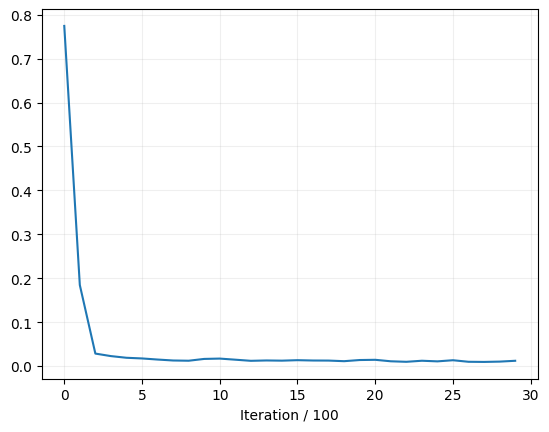

In [23]:
vel_loss = []

start_time = time.time()

for i in tqdm(range(3000)):
    vel_optimizer.zero_grad()
    
    t_orig, t, xt, mu_t_dot, eps = get_batch_vel(geo_model, x_train, v_train, batch_size, sigma, train_ts)
    vt = vel_model(torch.cat([xt.detach(), t[:, None]], dim=-1))
    
    loss = torch.mean((vt - mu_t_dot.detach()) ** 2)

    loss.backward() 
    vel_optimizer.step()

    if i % 100 == 0:
        vel_loss.append(loss.cpu().item())


end_time = time.time()

train_time_curly_vel = end_time - start_time

plt.plot(vel_loss)
plt.grid(alpha=0.2)
plt.xlabel("Iteration / 100")

tensor(0.1452)
tensor(0.1043)
tensor(0.1370)
tensor(0.1447)
Avg Cosine distance:  0.06443968
Avg L2 cost:  0.13279848
Avg Wass-2 distance:  0.03438355654374768

----------------------

t            Cosine-dist    &      L2 cost       &       Wass-2 
t2 --- 0.23686057329177856 & 0.1452229768037796 & 0.02664049059679094 \\
t4 --- 0.01776343397796154 & 0.10431492328643799 & 0.052928221276709576 \\
t6 --- 0.001684766379185021 & 0.13696599006652832 & 0.026221225941700548 \\
t8 --- 0.0014499382814392447 & 0.14469002187252045 & 0.03174428835978966 \\

Curly training time -- 2:16 (mins:secs)


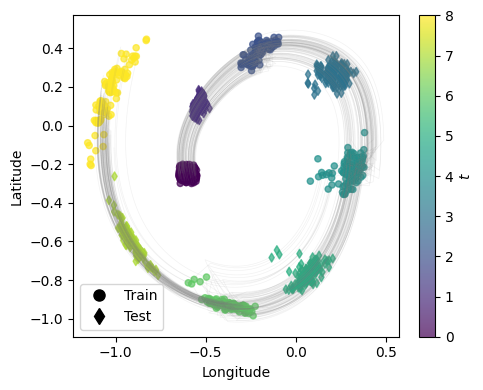

In [24]:
with torch.no_grad():
    trajs = []
    for t in range(len(train_ts) - 1):
        x0 = torch.from_numpy(x_train[t]).float().to(device)
        x1 = torch.from_numpy(x_train[t + 1]).float().to(device)
        v0 = torch.from_numpy(v_train[t]).float().to(device)
        v1 = torch.from_numpy(v_train[t + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(vel_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        out = node.trajectory(
            z0,
            t_span=torch.linspace(t, t + 1, 100),
        ).cpu()

        traj_tmp = out[:, :, :-2]

        trajs.append(traj_tmp)

    traj_curly = torch.cat(trajs, dim=0)

    plt.figure(figsize=(5, 4))

    wass1, cos_dist, L2_cost = [], [], []
    for t, t_train in enumerate(train_ts[:-1]):
        x0 = torch.from_numpy(positions[t_train]).float().to(device)
        x1 = torch.from_numpy(positions[t_train + 1]).float().to(device)
        v0 = torch.from_numpy(velocities[t_train]).float().to(device)
        v1 = torch.from_numpy(velocities[t_train + 1]).float().to(device)

        wrapped_model = CurlyWrapperWithMetrics(vel_model, x0, x1, v0, v1, k)
        node = NeuralODE(wrapped_model, solver="euler", sensitivity="adjoint")

        z0 = torch.cat([x0, torch.zeros(x0.shape[0], 2, device=x0.device)], dim=1)

        pred_out = node.trajectory(
            z0.to(device),
            t_span=torch.linspace(t, t + 1 / 2, 100),
        ).cpu()

        pred_traj = pred_out[:, :, :-2]
        cosine_traj = pred_out[:, :, -2]
        L2_traj = pred_out[:, :, -1]

        pred = pred_traj[-1]

        cos_dist.append(cosine_traj[-1].cpu().mean())
        L2_cost.append(L2_traj[-1].cpu().mean())

        print(L2_traj[-1].cpu().mean())

        wass1.append(optimal_transport.wasserstein(pred, x1.cpu(), power=1))

    cos_dist = np.stack(cos_dist)
    L2_cost = np.stack(L2_cost)

    print("Avg Cosine distance: ", np.mean(cos_dist))
    print("Avg L2 cost: ", np.mean(L2_cost))

    wass1 = np.stack(wass1)
    print("Avg Wass-2 distance: ", np.mean(wass1))

    print()
    print("----------------------")
    print()
    print("t            Cosine-dist    &      L2 cost       &       Wass-2 ")
    for i, t_left_out in enumerate(["t2", "t4", "t6", "t8"]):
        print(t_left_out + f" --- {cos_dist[i]} & {L2_cost[i]} & {wass1[i]} \\\\")

    train_time_curly = train_time_curly_geo + train_time_curly_vel
    minutes = int(train_time_curly // 60)
    seconds = int(train_time_curly % 60)

    print()
    print(f"Curly training time -- {minutes}:{seconds} (mins:secs)")

    plot_trajectories_on_data(
        positions,
        traj_curly.cpu().numpy(),
        num_trajectories=100,
        ts_train=train_ts,
        ts_test=test_ts,
    )
